## Reinforcement Fine Tuning  


[Reinforcement fine-tuning (RFT)]() involves applying reinforcement learning techniques to existing models to enhance their reasoning capabilities. By exploring various solutions and rewarding effective strategies, RFT enables the model to make more precise decisions and better understand context. This approach results in improved performance and more accurate interpretations.


In this guided notebook, weʼll walk through how to apply RFT to the Nova Lite 2.0 reasoning model following where we stopped in `02_SFT_Eval.ipynb`. 

### By the end of this notebook you will learn:
- **[1. How to Prepare Dataset for RFT](#1)**
- **[2. How to Build a reward function](#2)**
- **[3. How to Kick off RFT Job using SageMaker Training Jobs](#3)**
- **[4. How to Evaluate the Custom Model using Nova Evaluation Container](#4)**


## **1. Introduction**

### Reinforcement Fine-Tuning (RFT)

Reinforcement Fine-Tuning (RFT) is a machine learning technique that improves model performance through feedback signals—measurable scores or rewards indicating response quality—rather than direct supervision with exact correct answers. Unlike traditional supervised fine-tuning that learns from input-output pairs, RFT uses reward functions to evaluate model responses and iteratively optimizes the model to maximize these rewards. This approach is particularly effective for tasks where defining the exact correct output is challenging, but you can reliably measure response quality. RFT enables models to learn complex behaviors and preferences through trial and feedback, making it ideal for applications requiring nuanced decision-making, creative problem-solving, or adherence to specific quality criteria that can be programmatically evaluated.


###  How Does It Work?

Reinforcement fine-tuning uses GRPO (Group Relative Policy Optimization), in which you start from an instruction-tuned baseline and treat each prompt like a small tournament: for a given input, you sample a handful of candidate answers from the model, score each one with the reward function, then rank them within that group. The update step simply nudges the model to make higher-scoring candidates more likely next time and lower-scoring ones less likely, while a stay-close-to-baseline constraint keeps behavior from drifting or becoming verbose or exploitative. You repeat this loop over many prompts, refreshing hard cases, tightening verifiers or judge rubrics when you see exploits, and continuously tracking task metrics.

###  When to Use RFT?

Tasks that benefit most from RFT share a few traits. They have measurable success signals even when a single correct output is hard to specify; they admit partial credit or graded quality (so better vs. worse answers can be ranked within a prompt or using a reward function); they involve multiple objectives that must be balanced (e.g., accuracy with brevity, clarity, safety, or cost); they require adherence to explicit constraints that can be programmatically checked; they operate in tool-mediated or environment-based settings where outcomes are observable (success/failure, latency, resource use); and they occur in low-label regimes where collecting gold targets is expensive but automated or rubric-based feedback is plentiful. In short, RFT shines wherever you can turn quality into a reliable scalar or ranking and want the model to preferentially amplify higher-scoring behaviors without needing exhaustive labeled targets.

Consider other methods when:

* You have plentiful, reliable labeled input-output pairs → use SFT
* The main gap is knowledge/jargon → use retrieval-augmented generation (RAG)
* Your reward signal is noisy/unreliable and can't be fixed with better rubrics/checkers → stabilize that first before RFT

###  When NOT to Use RFT?

* Avoid RFT when you can cheaply produce reliable labeled input-output pairs (SFT will be simpler, cheaper, and more stable); 
* when the gap is knowledge/jargon rather than behavior (prefer RAG); 
* when your reward signal is noisy, sparse, easy to game, or expensive/slow to compute (fix the evaluator first); 
* when baseline performance is near-zero (bootstrap with SFT before optimizing preferences); 
* when the task has deterministic schemas, strict formatting, or a single correct answer (SFT or rule-based validation works better); 
* when tight latency/cost budgets can't absorb the extra sampling/exploration RFT requires; 
* or when safety/policy constraints aren't crisply specified and enforceable in the reward.


In short: if you can point to "the right answer," do SFT; if you need new knowledge, use RAG; use RFT only after you have a solid baseline and a robust, fast, hard-to-exploit reward function.

![imgs/Final_rft.gif](imgs/Final_rft.gif)
### 1. Setting up the IAM roles


In [ ]:
import json
import time
import os
import sagemaker
import json
import boto3
import matplotlib.pyplot as plt

# Get region with fallback
region = os.environ.get('AWS_DEFAULT_REGION') or boto3.Session().region_name or 'us-east-1'
sagemaker_session_bucket = None

sm = boto3.client('sagemaker', region_name='us-east-1')
sess = sagemaker.session.Session(boto_session=boto3.session.Session(), sagemaker_client=sm)

if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client("iam")
    role = iam.get_role(RoleName="sagemaker_execution_role")["Role"]["Arn"]

bucket_name = sess.default_bucket()
default_prefix = sess.default_bucket_prefix

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

### Import Helper Utility Package

In [ ]:
from utils.lambda_deployer import create_lambda_function
from utils.lambda_role_helper import get_or_create_lambda_role
from utils import add_lambda_invoke_permission_to_customization_role
from utils.s3_tar_downloader import download_and_unpack_s3_tar
from utils.plots import plot_step_wise_training_metrics

### 2. Data Preperation for RFT.

RFT training data must follow the OpenAI Reinforcement Fine-Tuning format. Each training example is a JSON object containing:

* A messages array with conversational turns using system and user roles
* A reference_answer field containing the expected output or evaluation criteria for reward calculation

Current Limitations

* Text only

Data Format Examples

Each example should be on a single line in your JSONL file, with one JSON object per line. Sample data format.


```json
{
    "messages": [
        {
            "role": "system",
            "content": "str"

        },        
        {
            "role": "user",
            "content": "str"
        }
    ]
    "reference_answer":{

    }
}
```

#### Restoring saved S3 Checkpoint of SFT model and results, and RFT data

In [ ]:
%store -r checkpoint_S3_uri
%store -r results_df
%store -r train_dataset_s3_path_rft
%store -r test_dataset_s3_path_rft
%store -r val_dataset_s3_path_rftf


### 2. How to build the reward Function

Reward functions are implemented as AWS Lambda functions that evaluate model responses and return numerical scores. The Lambda function receives messages and ground truth in the OpenAI format and must return scores as a dictionary. For the basic example no additional Lambda layers are required

#### Input Payload for the lambda function

RFT internally append the assistant turn (generated response) to the last turn of messages field and a unique id . The payload to the reward lambda is same as the output of the generated response.


```json
[{  
   "id": "str",
    "messages": [
        {
            "role": "system",
            "content": < pass through as is from input data point>
        }
        {
            "role": "user",
            "content": < pass through as is from input data point>
        },
        {
            "role": "assistant",
            "content": <models prediction are appended >
        }
    ],            
    # Following section will be same as your training dataset sample
    "reference_answer": {
        <pass through as is from the input data point>
    }
}]
```


### Output Payload from the lambda function

```json
{
            "id": str,                              # Same id as input sample
            "aggregate_reward_score": float,        # Overall score for the sample(Numerical)
            "metrics_list": [                       # OPTIONAL: Component-wise scores
                {
                    "name": str,                    # Name of the component score
                    "value": float,                 # Value of the component score
                    "type": str                     # "Reward" or "Metric"
                }
            ]
        }
```



#### Build your reward function > Step 1: Lets build the evaluation metric and save as a lambda_reward_function.py


In [ ]:
%%writefile lambda_reward_function.py
import json
from typing import Dict, List, Any


def extract_json_from_markdown(text: str) -> str:
    """
    Extract JSON from markdown format with solution tags.
    
    Handles formats like:
    <|begin_of_solution|>```json
    {"key": "value"}
    ```<|end_of_solution|>
    
    Args:
        text: Raw text potentially containing solution tags and markdown
        
    Returns:
        Cleaned JSON string
    """
    if not isinstance(text, str):
        return text
    
    content = text
    
    # Remove solution tags if present
    if '<|begin_of_solution|>' in content:
        content = content.split('<|begin_of_solution|>')[-1]
    if '<|end_of_solution|>' in content:
        content = content.split('<|end_of_solution|>')[0]
    
    # Remove markdown code fences
    content = content.strip()
    
    # Handle ```json or ```
    if content.startswith('```json'):
        content = content[7:]  # Remove ```json
    elif content.startswith('```'):
        content = content[3:]  # Remove ```
    
    if content.endswith('```'):
        content = content[:-3]
    
    # Remove any escaped newlines that might be in the string
    content = content.replace('\\n', '\n')
    
    return content.strip()


def lambda_handler(event, context):
    """
    AWS Lambda handler function.

    Args:
        event: The Lambda event data
        context: The Lambda context

    Returns:
        List of dictionaries with reward scores
    """
    return lambda_grader(event)


def lambda_grader(samples: list[dict]) -> list[dict]:
    """
    Grade samples by comparing assistant responses against ground truth.

    Args:
        samples: List of dictionaries in OpenAI format

        Example input (List of such sample):
        {   
            "id": "123",
            "messages": [
                {
                    "role": "user",
                    "content": "What tools do I need for stock analysis?"
                },
                {
                    "role": "assistant",
                    "content": "{\"Type\": [\"information_retrieval\"], \"Tools\": [...]}"
                }
            ],            
            "reference_answer": {
                "Type": ["information_retrieval", "analysis"],
                "Information needed": "Stock data",
                "Tools": [
                    {
                        "Tool": "web_search",
                        "Parameters": {"query": "stock price"},
                        "Reasoning": "Get data"
                    }
                ]
            }
        }

    Returns:
        List of dictionaries with reward scores:
        {
            "id": str,
            "aggregate_reward_score": float,
            "metrics_list": [
                {
                    "name": str,
                    "value": float,
                    "type": str  # "Reward" or "Metric"
                }
            ]
        }
    """
    evaluator = QueryAnalysisEvaluator()
    results = []

    for sample in samples:

        sample_id = sample.get("id", "unknown")

        # Extract assistant's response from messages
        assistant_content = ""
        for message in sample.get("messages", []):
            if message.get("role") == "assistant":
                assistant_content = message.get("content", "")
                break

        # Parse assistant's JSON response
        try:
            # Handle solution tags and markdown code blocks
            content = assistant_content.strip()
            print(f"[DEBUG] Original content length: {len(content)}")
            print(f"[DEBUG] First 100 chars: {content[:100]}")

            # Extract JSON from markdown format with solution tags
            content = extract_json_from_markdown(content)
            print(f"[DEBUG] After extraction: {content[:200]}")

            predicted_output = json.loads(content)
            print(f"[DEBUG] Parsed JSON successfully")
            print(f"[DEBUG] Top-level keys: {list(predicted_output.keys())}")

            # Handle nested structure like {"Query analysis": {...}}
            if "Query analysis" in predicted_output:
                print(f"[DEBUG] Found 'Query analysis' key, extracting nested structure")
                predicted_output = predicted_output["Query analysis"]
                print(f"[DEBUG] Extracted keys: {list(predicted_output.keys())}")

            # Normalize predicted output: ensure Type is a list
            if "Type" in predicted_output and isinstance(predicted_output["Type"], str):
                predicted_output["Type"] = [predicted_output["Type"]]
                print(f"[DEBUG] Normalized predicted output Type from string to list")

        except (json.JSONDecodeError, KeyError, TypeError) as e:
            print(f"[ERROR] Error parsing JSON for sample {sample_id}: {e}")
            print(f"[ERROR] Content: {assistant_content[:200]}")
            # If parsing fails, return zero scores
            results.append({
                "id": sample_id,
                "aggregate_reward_score": 0.0,
                "metrics_list": [
                    {"name": "schema_valid", "value": 0.0, "type": "Metric"},
                    {"name": "tool_precision", "value": 0.0, "type": "Metric"},
                    {"name": "tool_recall", "value": 0.0, "type": "Metric"},
                    {"name": "tool_f1", "value": 0.0, "type": "Metric"},
                    {"name": "parameter_accuracy", "value": 0.0, "type": "Metric"},
                    {"name": "sequence_accuracy", "value": 0.0, "type": "Metric"},
                    {"name": "overall_score", "value": 0.0, "type": "Reward"}
                ]
            })
            continue

        # Extract ground truth from reference_answer
        if "reference_answer" in sample:
            ground_truth = sample["reference_answer"]

            # Normalize ground truth: ensure Type is a list
            if "Type" in ground_truth and isinstance(ground_truth["Type"], str):
                ground_truth = ground_truth.copy()  # Don't modify original
                ground_truth["Type"] = [ground_truth["Type"]]
                print(f"[DEBUG] Normalized ground truth Type from string to list")
        else:
            # No ground truth available
            results.append({
                "id": sample_id,
                "aggregate_reward_score": 0.0,
                "metrics_list": [
                    {"name": "error", "value": 0.0, "type": "Metric"}
                ]
            })
            continue

        # Evaluate the response
        try:
            print(f"[DEBUG] Starting evaluation for sample {sample_id}")
            print(f"[DEBUG] Ground truth keys: {list(ground_truth.keys())}")
            print(f"[DEBUG] Predicted output keys: {list(predicted_output.keys())}")

            eval_result = evaluator.evaluate(ground_truth, predicted_output)
            print(f"[DEBUG] Evaluation completed successfully")
            print(f"[DEBUG] Schema validation: {eval_result['schema_validation']['passed']}")
            print(f"[DEBUG] Tool matching F1: {eval_result['tool_matching']['f1']}")
            print(f"[DEBUG] Parameter accuracy: {eval_result['parameter_matching']['accuracy']}")
            print(f"[DEBUG] Sequence accuracy: {eval_result['sequence_matching']['sequence_accuracy']}")
        except Exception as e:
            print(f"[ERROR] Exception during evaluation: {type(e).__name__}: {e}")
            import traceback
            traceback.print_exc()
            # Return zero scores on evaluation error
            results.append({
                "id": sample_id,
                "aggregate_reward_score": 0.0,
                "metrics_list": [
                    {"name": "evaluation_error", "value": 0.0, "type": "Metric"}
                ]
            })
            continue

        # Calculate aggregate reward score
        aggregate_score = eval_result["overall_score"]
        print(f"[DEBUG] Overall score: {aggregate_score}")

        # Build metrics list
        metrics_list = [
            {
                "name": "schema_valid",
                "value": 1.0 if eval_result["schema_validation"]["passed"] else 0.0,
                "type": "Metric"
            },
            {
                "name": "tool_precision",
                "value": eval_result["tool_matching"]["precision"],
                "type": "Metric"
            },
            {
                "name": "tool_recall",
                "value": eval_result["tool_matching"]["recall"],
                "type": "Metric"
            },
            {
                "name": "tool_f1",
                "value": eval_result["tool_matching"]["f1"],
                "type": "Metric"
            },
            {
                "name": "parameter_accuracy",
                "value": eval_result["parameter_matching"]["accuracy"],
                "type": "Metric"
            },
            {
                "name": "sequence_accuracy",
                "value": eval_result["sequence_matching"]["sequence_accuracy"],
                "type": "Metric"
            },
            {
                "name": "lcs_ratio",
                "value": eval_result["sequence_matching"]["lcs_ratio"],
                "type": "Metric"
            },
            {
                "name": "overall_score",
                "value": aggregate_score,
                "type": "Reward"
            }
        ]

        # Format the result according to required schema
        result = {
            "id": sample_id,
            "aggregate_reward_score": aggregate_score,
            "metrics_list": metrics_list
        }

        results.append(result)

    print("*"*100)
    print(results)
    print("*"*100)

    return results


class QueryAnalysisEvaluator:
    """Evaluator for query analysis outputs"""

    def __init__(self, edit_distance_threshold: float = 0.8):
        """
        Args:
            edit_distance_threshold: Minimum similarity score for string matching (0-1)
        """
        self.edit_distance_threshold = edit_distance_threshold

    def evaluate(self, gold_answer: Dict, inference_output: Dict) -> Dict[str, Any]:
        """
        Evaluate inference output against gold answer

        Args:
            gold_answer: Ground truth query analysis
            inference_output: Model's predicted query analysis

        Returns:
            Dict with all metrics
        """
        schema_result = self.validate_schema(inference_output)
        tool_result = self.evaluate_tools(gold_answer, inference_output)
        param_result = self.evaluate_parameters(gold_answer, inference_output)
        sequence_result = self.evaluate_sequence(gold_answer, inference_output)

        # Calculate overall score
        overall = self._calculate_overall_score(
            schema_result, tool_result, param_result, sequence_result
        )

        return {
            "schema_validation": schema_result,
            "tool_matching": tool_result,
            "parameter_matching": param_result,
            "sequence_matching": sequence_result,
            "overall_score": overall
        }

    # ============= 1. SCHEMA VALIDATION =============
    def validate_schema(self, output: Dict) -> Dict[str, Any]:
        """
        Validate if output matches expected schema

        Returns:
            Dict with 'passed' (bool) and 'errors' (list)
        """
        errors = []

        # Check top-level keys
        required_keys = {"Type", "Information needed", "Tools"}
        if not isinstance(output, dict):
            return {"passed": False, "errors": ["Output is not a dictionary"]}

        missing_keys = required_keys - set(output.keys())
        if missing_keys:
            errors.append(f"Missing required keys: {missing_keys}")

        # Validate Type field
        if "Type" in output:
            if not isinstance(output["Type"], list):
                errors.append("'Type' must be a list")
            elif not all(isinstance(t, str) for t in output["Type"]):
                errors.append("'Type' must be a list of strings")

        # Validate Information needed field
        if "Information needed" in output:
            if not isinstance(output["Information needed"], str):
                errors.append("'Information needed' must be a string")

        # Validate Tools field
        if "Tools" in output:
            if not isinstance(output["Tools"], list):
                errors.append("'Tools' must be a list")
            else:
                for i, tool in enumerate(output["Tools"]):
                    tool_errors = self._validate_tool_schema(tool, i)
                    errors.extend(tool_errors)

        return {
            "passed": len(errors) == 0,
            "errors": errors
        }

    def _validate_tool_schema(self, tool: Any, index: int) -> List[str]:
        """Validate individual tool schema"""
        errors = []

        if not isinstance(tool, dict):
            errors.append(f"Tool at index {index} is not a dictionary")
            return errors

        required_tool_keys = {"Tool", "Parameters", "Reasoning"}
        missing_keys = required_tool_keys - set(tool.keys())
        if missing_keys:
            errors.append(f"Tool at index {index} missing keys: {missing_keys}")

        if "Tool" in tool and not isinstance(tool["Tool"], str):
            errors.append(f"Tool at index {index}: 'Tool' must be a string")

        if "Parameters" in tool and not isinstance(tool["Parameters"], dict):
            errors.append(f"Tool at index {index}: 'Parameters' must be a dict")

        if "Reasoning" in tool and not isinstance(tool["Reasoning"], str):
            errors.append(f"Tool at index {index}: 'Reasoning' must be a string")

        return errors

    # ============= 2. TOOL MATCHING =============
    def evaluate_tools(self, gold: Dict, pred: Dict) -> Dict[str, Any]:
        """
        Evaluate if the right tools are called

        Returns:
            Dict with precision, recall, f1, and details
        """
        if "Tools" not in gold or "Tools" not in pred:
            return {
                "precision": 0.0,
                "recall": 0.0,
                "f1": 0.0,
                "matched_tools": [],
                "missing_tools": [],
                "extra_tools": []
            }

        gold_tools = {tool["Tool"] for tool in gold["Tools"]}
        pred_tools = {tool["Tool"] for tool in pred["Tools"]}

        matched = gold_tools & pred_tools
        missing = gold_tools - pred_tools
        extra = pred_tools - gold_tools

        precision = len(matched) / len(pred_tools) if pred_tools else 0.0
        recall = len(matched) / len(gold_tools) if gold_tools else 0.0
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

        return {
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "matched_tools": list(matched),
            "missing_tools": list(missing),
            "extra_tools": list(extra)
        }

    # ============= 3. PARAMETER MATCHING =============
    def evaluate_parameters(self, gold: Dict, pred: Dict) -> Dict[str, Any]:
        """
        Evaluate if tools are called with correct parameters
        Uses edit distance for string comparisons

        Returns:
            Dict with accuracy and per-tool parameter scores
        """
        if "Tools" not in gold or "Tools" not in pred:
            return {"accuracy": 0.0, "tool_scores": {}}

        # Create tool name to parameters mapping
        gold_params = {tool["Tool"]: tool.get("Parameters", {}) 
                       for tool in gold["Tools"]}
        pred_params = {tool["Tool"]: tool.get("Parameters", {}) 
                       for tool in pred["Tools"]}

        tool_scores = {}
        total_score = 0.0
        tools_evaluated = 0

        for tool_name in set(gold_params.keys()) & set(pred_params.keys()):
            score = self._compare_parameters(
                gold_params[tool_name], 
                pred_params[tool_name]
            )
            tool_scores[tool_name] = score
            total_score += score
            tools_evaluated += 1

        accuracy = total_score / tools_evaluated if tools_evaluated > 0 else 0.0

        return {
            "accuracy": accuracy,
            "tool_scores": tool_scores
        }

    def _compare_parameters(self, gold_params: Dict, pred_params: Dict) -> float:
        """Compare parameter dictionaries and return similarity score"""
        if not gold_params and not pred_params:
            return 1.0

        if not gold_params or not pred_params:
            return 0.0

        # Check key overlap
        gold_keys = set(gold_params.keys())
        pred_keys = set(pred_params.keys())

        if gold_keys != pred_keys:
            key_score = len(gold_keys & pred_keys) / len(gold_keys | pred_keys)
        else:
            key_score = 1.0

        # Compare values for matching keys
        value_scores = []
        for key in gold_keys & pred_keys:
            gold_val = gold_params[key]
            pred_val = pred_params[key]
            value_scores.append(self._compare_values(gold_val, pred_val))

        value_score = sum(value_scores) / len(value_scores) if value_scores else 0.0

        # Combined score (weighted average)
        return 0.3 * key_score + 0.7 * value_score

    def _compare_values(self, gold_val: Any, pred_val: Any) -> float:
        """Compare individual parameter values"""
        # Handle lists
        if isinstance(gold_val, list) and isinstance(pred_val, list):
            if not gold_val and not pred_val:
                return 1.0
            gold_set = set(str(v) for v in gold_val)
            pred_set = set(str(v) for v in pred_val)
            intersection = len(gold_set & pred_set)
            union = len(gold_set | pred_set)
            return intersection / union if union > 0 else 0.0

        # Handle strings with edit distance
        if isinstance(gold_val, str) and isinstance(pred_val, str):
            return self._string_similarity(gold_val, pred_val)

        # Handle other types with exact match
        return 1.0 if gold_val == pred_val else 0.0

    def _string_similarity(self, s1: str, s2: str) -> float:
        """Calculate string similarity using character overlap"""
        s1_lower = s1.lower()
        s2_lower = s2.lower()

        if not s1_lower or not s2_lower:
            return 0.0 if s1_lower != s2_lower else 1.0

        # Calculate character-level overlap
        s1_chars = set(s1_lower)
        s2_chars = set(s2_lower)

        intersection = len(s1_chars & s2_chars)
        union = len(s1_chars | s2_chars)

        char_similarity = intersection / union if union > 0 else 0.0

        # Calculate token-level overlap
        s1_tokens = s1_lower.split()
        s2_tokens = s2_lower.split()

        if s1_tokens and s2_tokens:
            token_intersection = len(set(s1_tokens) & set(s2_tokens))
            token_union = len(set(s1_tokens) | set(s2_tokens))
            token_similarity = token_intersection / token_union if token_union > 0 else 0.0
        else:
            token_similarity = char_similarity

        # Combined similarity (weighted average)
        return 0.4 * char_similarity + 0.6 * token_similarity

    # ============= 4. SEQUENCE MATCHING =============
    def evaluate_sequence(self, gold: Dict, pred: Dict) -> Dict[str, Any]:
        """
        Evaluate if tools are called in the correct order

        Returns:
            Dict with sequence accuracy and alignment details
        """
        if "Tools" not in gold or "Tools" not in pred:
            return {
                "sequence_accuracy": 0.0,
                "lcs_ratio": 0.0,
                "correct_positions": 0,
                "total_positions": 0
            }

        gold_sequence = [tool["Tool"] for tool in gold["Tools"]]
        pred_sequence = [tool["Tool"] for tool in pred["Tools"]]

        # Longest Common Subsequence
        lcs_length = self._lcs_length(gold_sequence, pred_sequence)
        lcs_ratio = lcs_length / len(gold_sequence) if gold_sequence else 0.0

        # Positional accuracy (exact matches at same index)
        correct_positions = sum(
            1 for i in range(min(len(gold_sequence), len(pred_sequence)))
            if gold_sequence[i] == pred_sequence[i]
        )

        sequence_accuracy = correct_positions / len(gold_sequence) if gold_sequence else 0.0

        return {
            "sequence_accuracy": sequence_accuracy,
            "lcs_ratio": lcs_ratio,
            "correct_positions": correct_positions,
            "total_positions": len(gold_sequence),
            "gold_sequence": gold_sequence,
            "pred_sequence": pred_sequence
        }

    def _lcs_length(self, seq1: List[str], seq2: List[str]) -> int:
        """Calculate longest common subsequence length"""
        m, n = len(seq1), len(seq2)
        dp = [[0] * (n + 1) for _ in range(m + 1)]

        for i in range(1, m + 1):
            for j in range(1, n + 1):
                if seq1[i-1] == seq2[j-1]:
                    dp[i][j] = dp[i-1][j-1] + 1
                else:
                    dp[i][j] = max(dp[i-1][j], dp[i][j-1])

        return dp[m][n]

    # ============= OVERALL SCORE =============
    def _calculate_overall_score(
        self, 
        schema: Dict, 
        tools: Dict, 
        params: Dict, 
        sequence: Dict
    ) -> float:
        """Calculate weighted overall score"""
        if not schema["passed"]:
            return 0.0

        weights = {
            "tools": 0.3,
            "params": 0.3,
            "sequence": 0.4
        }

        score = (
            weights["tools"] * tools["f1"] +
            weights["params"] * params["accuracy"] +
            weights["sequence"] * sequence["sequence_accuracy"]
        )

        return score



Overwriting lambda_reward_function.py


#### Build your reward function > Step 2: Lets deploy this created lambda_reward_function.py to a lambda 


Now lets deploy a lambda function based on this reward_function 

In [ ]:
from utils.lambda_deployer import create_lambda_function
from utils.lambda_role_helper import get_or_create_lambda_role

# Deploy your Lambda function
role_arn = get_or_create_lambda_role(
    role_name="reward_function_lambda_role",
    managed_policies=[
        "arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole",
        "arn:aws:iam::aws:policy/AmazonBedrockFullAccess"
    ]
)
time.sleep(15)

arn = create_lambda_function(
    lambda_script_path="lambda_reward_function.py",
    function_name="code-talk-reward-fn",
    role_arn=role_arn,
    skip_if_exists=True
)

print(f"Lambda ARN: {arn}")

#### Build your reward function > Step 3: Lets attach Lambda Invocation Polciy to our SageMaker Role which will be used for RFT

One more thing to note, is to make sure our SageMaker Execution role has access to call this Lambda, so lets go ahead and add that execution policy to our SageMaker Execution Role

In [ ]:
add_lambda_invoke_permission_to_customization_role(
    role_arn=role,
    lambda_function_arn=arn
)

### 3. How to kick off RFT Job using SageMaker Training Jobs

In [ ]:
instance_type = "ml.p5.48xlarge"
instance_count = 4
image_uri = "708977205387.dkr.ecr.us-east-1.amazonaws.com/nova-fine-tune-repo:SM-TJ-RFT-V2-latest"
model_id = "nova-lite-2/prod"
recipe = "fine-tuning/nova/nova_2_0/nova_lite/RFT/nova_lite_2_0_p5_gpu_lora_rft.yaml" # https://github.com/aws/sagemaker-hyperpod-recipes/blob/main/recipes_collection/recipes/fine-tuning/nova/nova_2_0/nova_lite/RFT/nova_lite_2_0_p5_gpu_lora_rft.yaml
post_sft_chkpt = checkpoint_S3_uri

from sagemaker.pytorch import PyTorch

# define Training Job Name
job_name = f"rft-lora-dewanup-{model_id.split('/')[0].replace('.', '-')}"

# define OutputDataConfig path
if default_prefix:
    output_path = f"s3://{bucket_name}/{default_prefix}/{job_name}"
else:
    output_path = f"s3://{bucket_name}/{job_name}"
    
recipe_overrides = {
    "run": {
        "reward_lambda_arn": arn,  
        "model_name_or_path": post_sft_chkpt,
    },
    "training_config": {
        "max_length": 8192,
        "global_batch_size": 64,
        "rollout": {
            "advantage_strategy": {
                "number_generation": 2
            },
            "generator": {
                "max_new_tokens": 6000,
                "top_k": 1
            },
            "rewards": {
                "api_endpoint": {
                    "lambda_arn": arn
                }
            }
        },
        "trainer": {
            "max_steps": 5,
            "ent_coeff": 0,
            "kl_loss_coef": 0.001,
            "optim_config": {
                "lr": 1e-4
            }

        }
    }
}

estimator = PyTorch(
    output_path=output_path,
    base_job_name=job_name,
    role=role,
    disable_profiler=True,
    debugger_hook_config=False,
    instance_count=instance_count,
    instance_type=instance_type,
    recipe_overrides=recipe_overrides,
    training_recipe=recipe,
    sagemaker_session=sess,
    image_uri=image_uri
)


from sagemaker.inputs import TrainingInput

train_input = TrainingInput(
    s3_data=train_dataset_s3_path_rft,
    distribution="FullyReplicated"
)

val_input = TrainingInput(
    s3_data=val_dataset_s3_path_rft,
    distribution="FullyReplicated"
)

estimator.fit(inputs={"train": train_input}, wait=True)

training_job_name = estimator.latest_training_job.name
print('Training Job Name:  {}'.format(training_job_name))


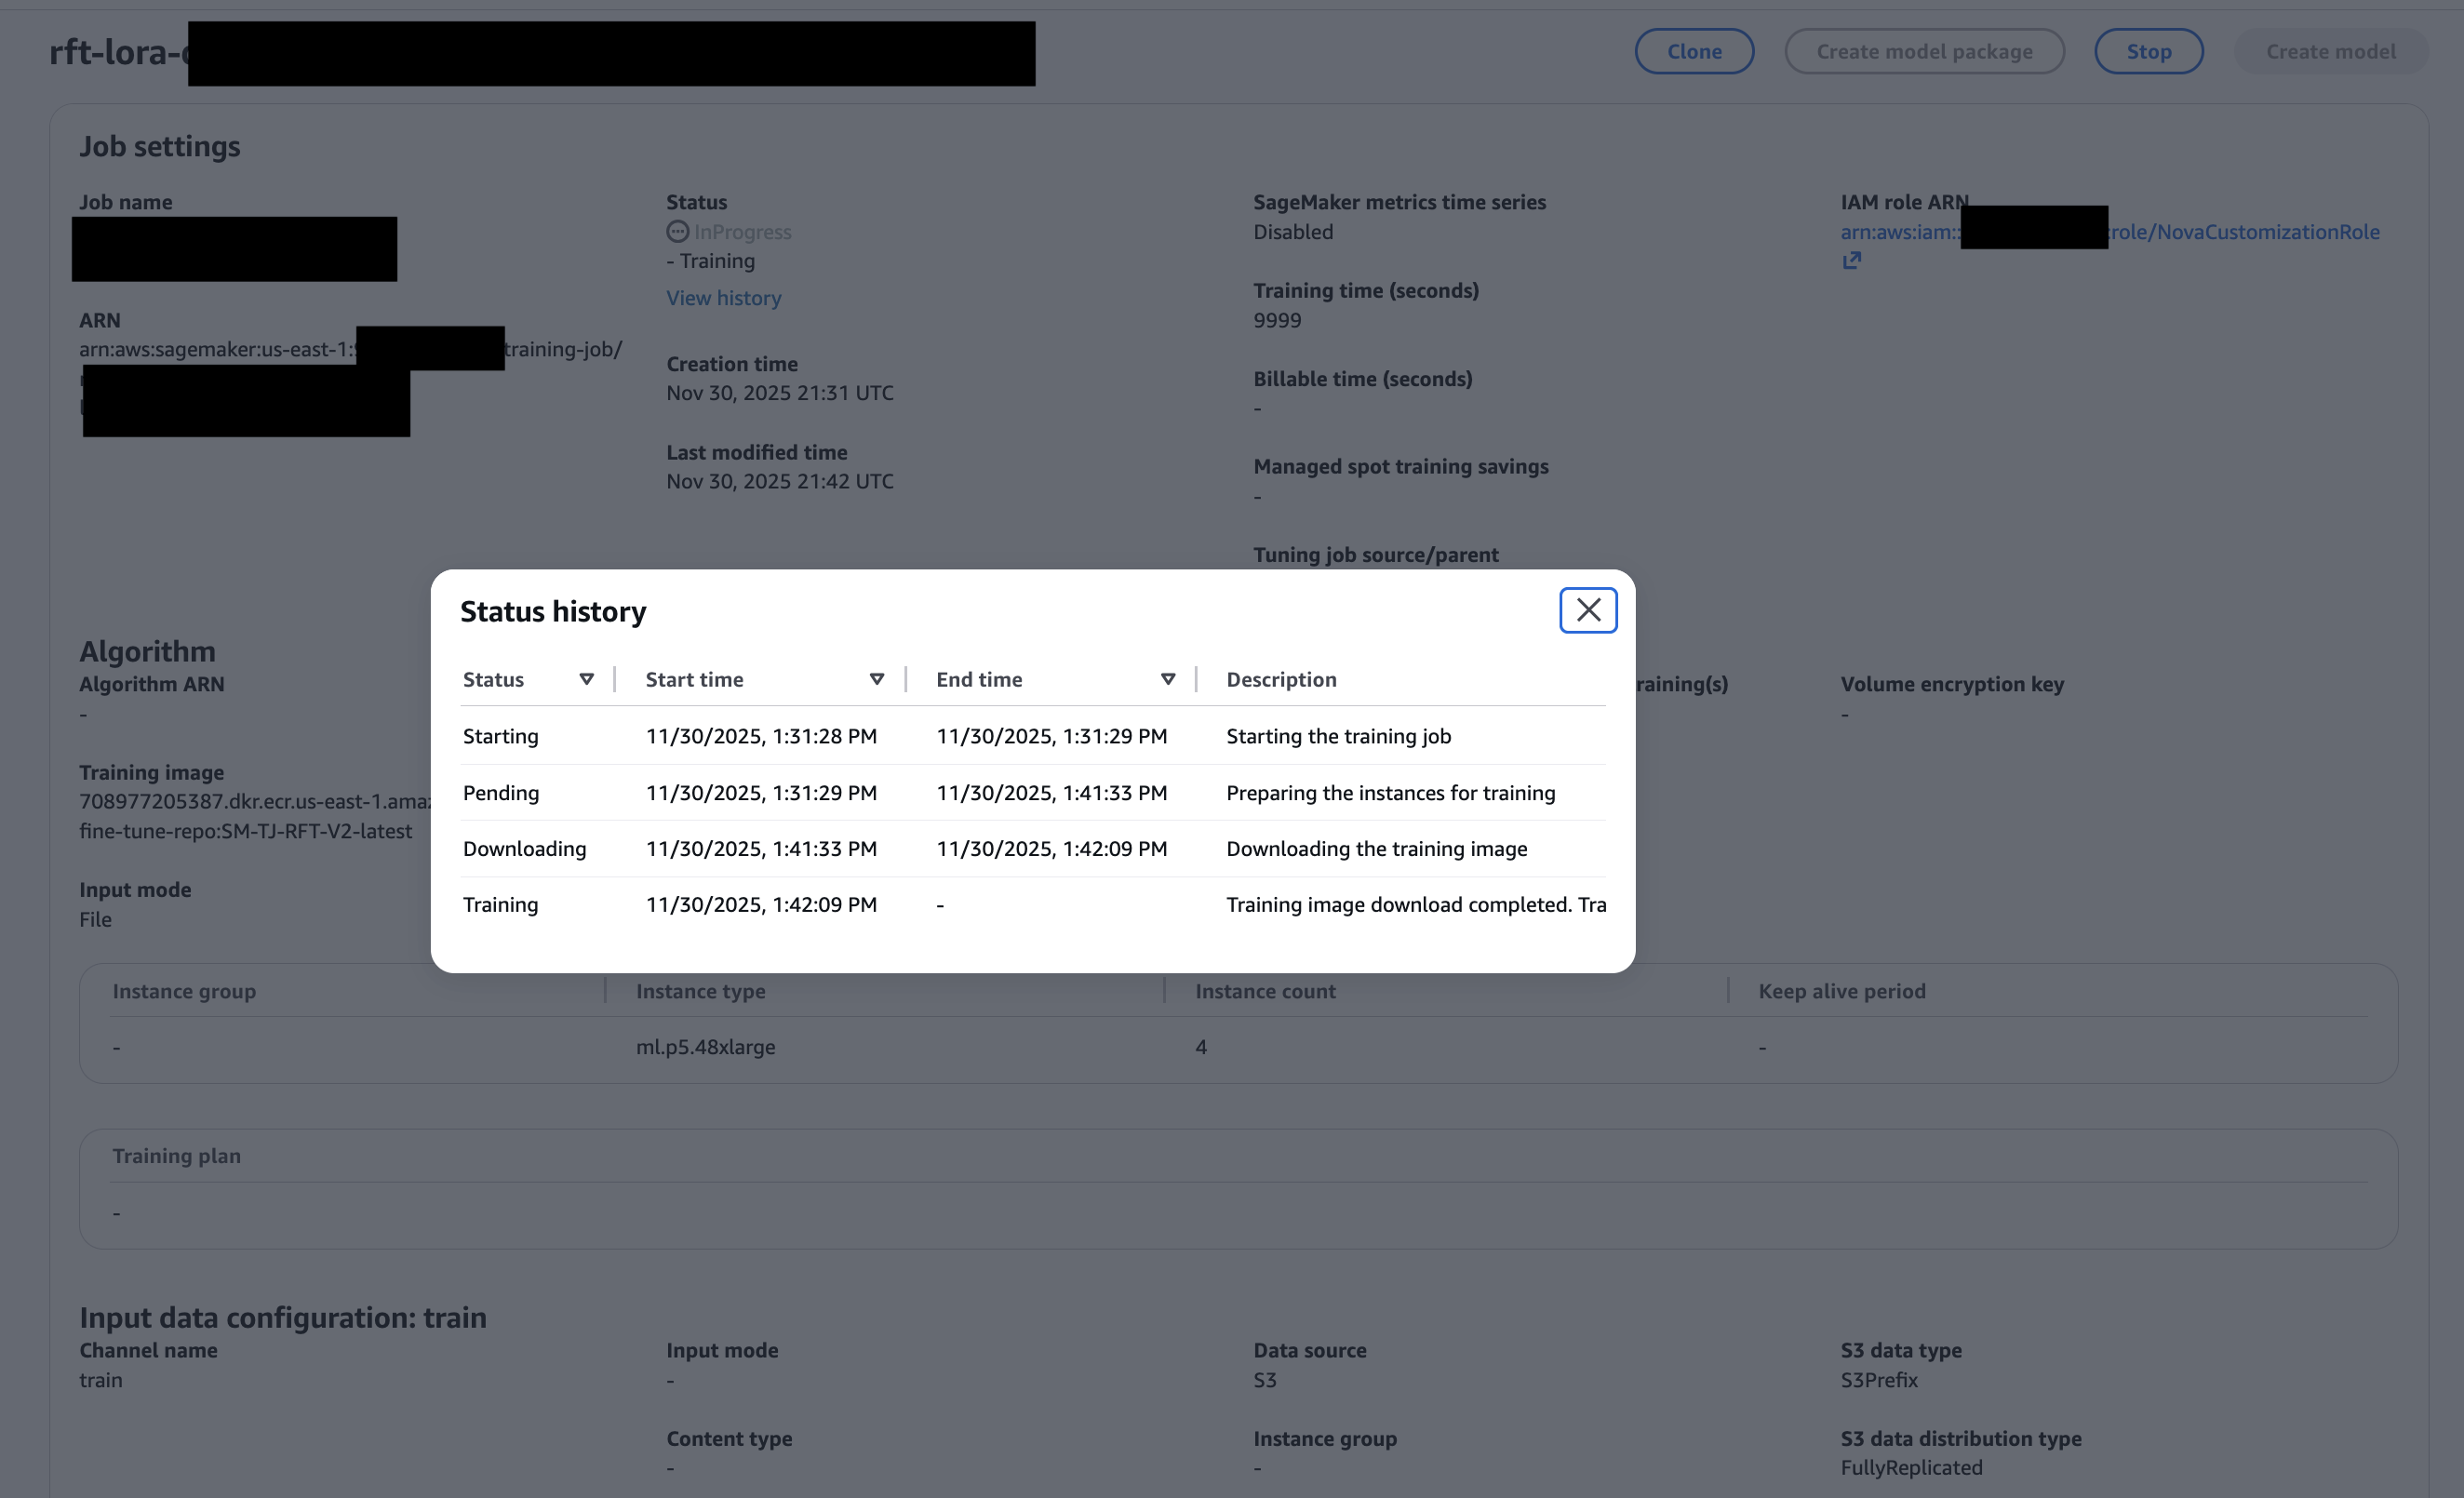

In [ ]:
from IPython.display import HTML, Markdown, Image

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}">Training Job</a> After About 5 Minutes</b>'.format("us-east-1", training_job_name)))



from IPython.display import HTML, Markdown, Image

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/TrainingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format("us-east-1", training_job_name)))




from IPython.display import HTML, Markdown, Image

display(HTML('<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Training Job Has Completed</b>'.format(bucket_name, training_job_name, "us-east-1")))



#### Unpack the output artifacts from the RFT run

Next, we will unpack the output artifacts that will have two important things
- `Manifest.json` - This is a critical file as it has the checkpoint information that has been generated post-RFT.
- `step_wise_training_metrics.csv` - This is file with all the relevent metrics that were captured including reward, entropy and other training metrics

In [ ]:
response = sm.describe_training_job(
            TrainingJobName=training_job_name
        )
        
# Extract the model artifacts S3 URI
output_s3_uri = response['ModelArtifacts']['S3ModelArtifacts']
output_s3_uri = output_s3_uri.replace("model.tar.gz", "output.tar.gz")

In [ ]:
files = download_and_unpack_s3_tar(
    bucket_name = bucket_name,
    s3_key=output_s3_uri,
    extract_to='./post-rft'
)

with open('./post-rft/manifest.json', 'r') as file:
    chkpt_info = json.load(file)

### 4. How to Meaure the "goodness" of RFT

Next to measure the goodness of RFT, we focus on couple of key metrics:

The two Key metrics to look are:
- **Critic Reward Distribution Metrics**: These help in finding how the reward shape looks like and if they are on a path of gradual increase.

`critic/rewards/mean`, `critic/rewards/max`, `critic/rewards/min`

- **Model Exploratory Behavior Metrics**: This metrics help us in understanding the exploratory nature of the model. The higher entropy indicates model higher the policy variuation and more models ability to exploring new paths. 

`actor/entropy`: Policy variation (higher = more exploratory)


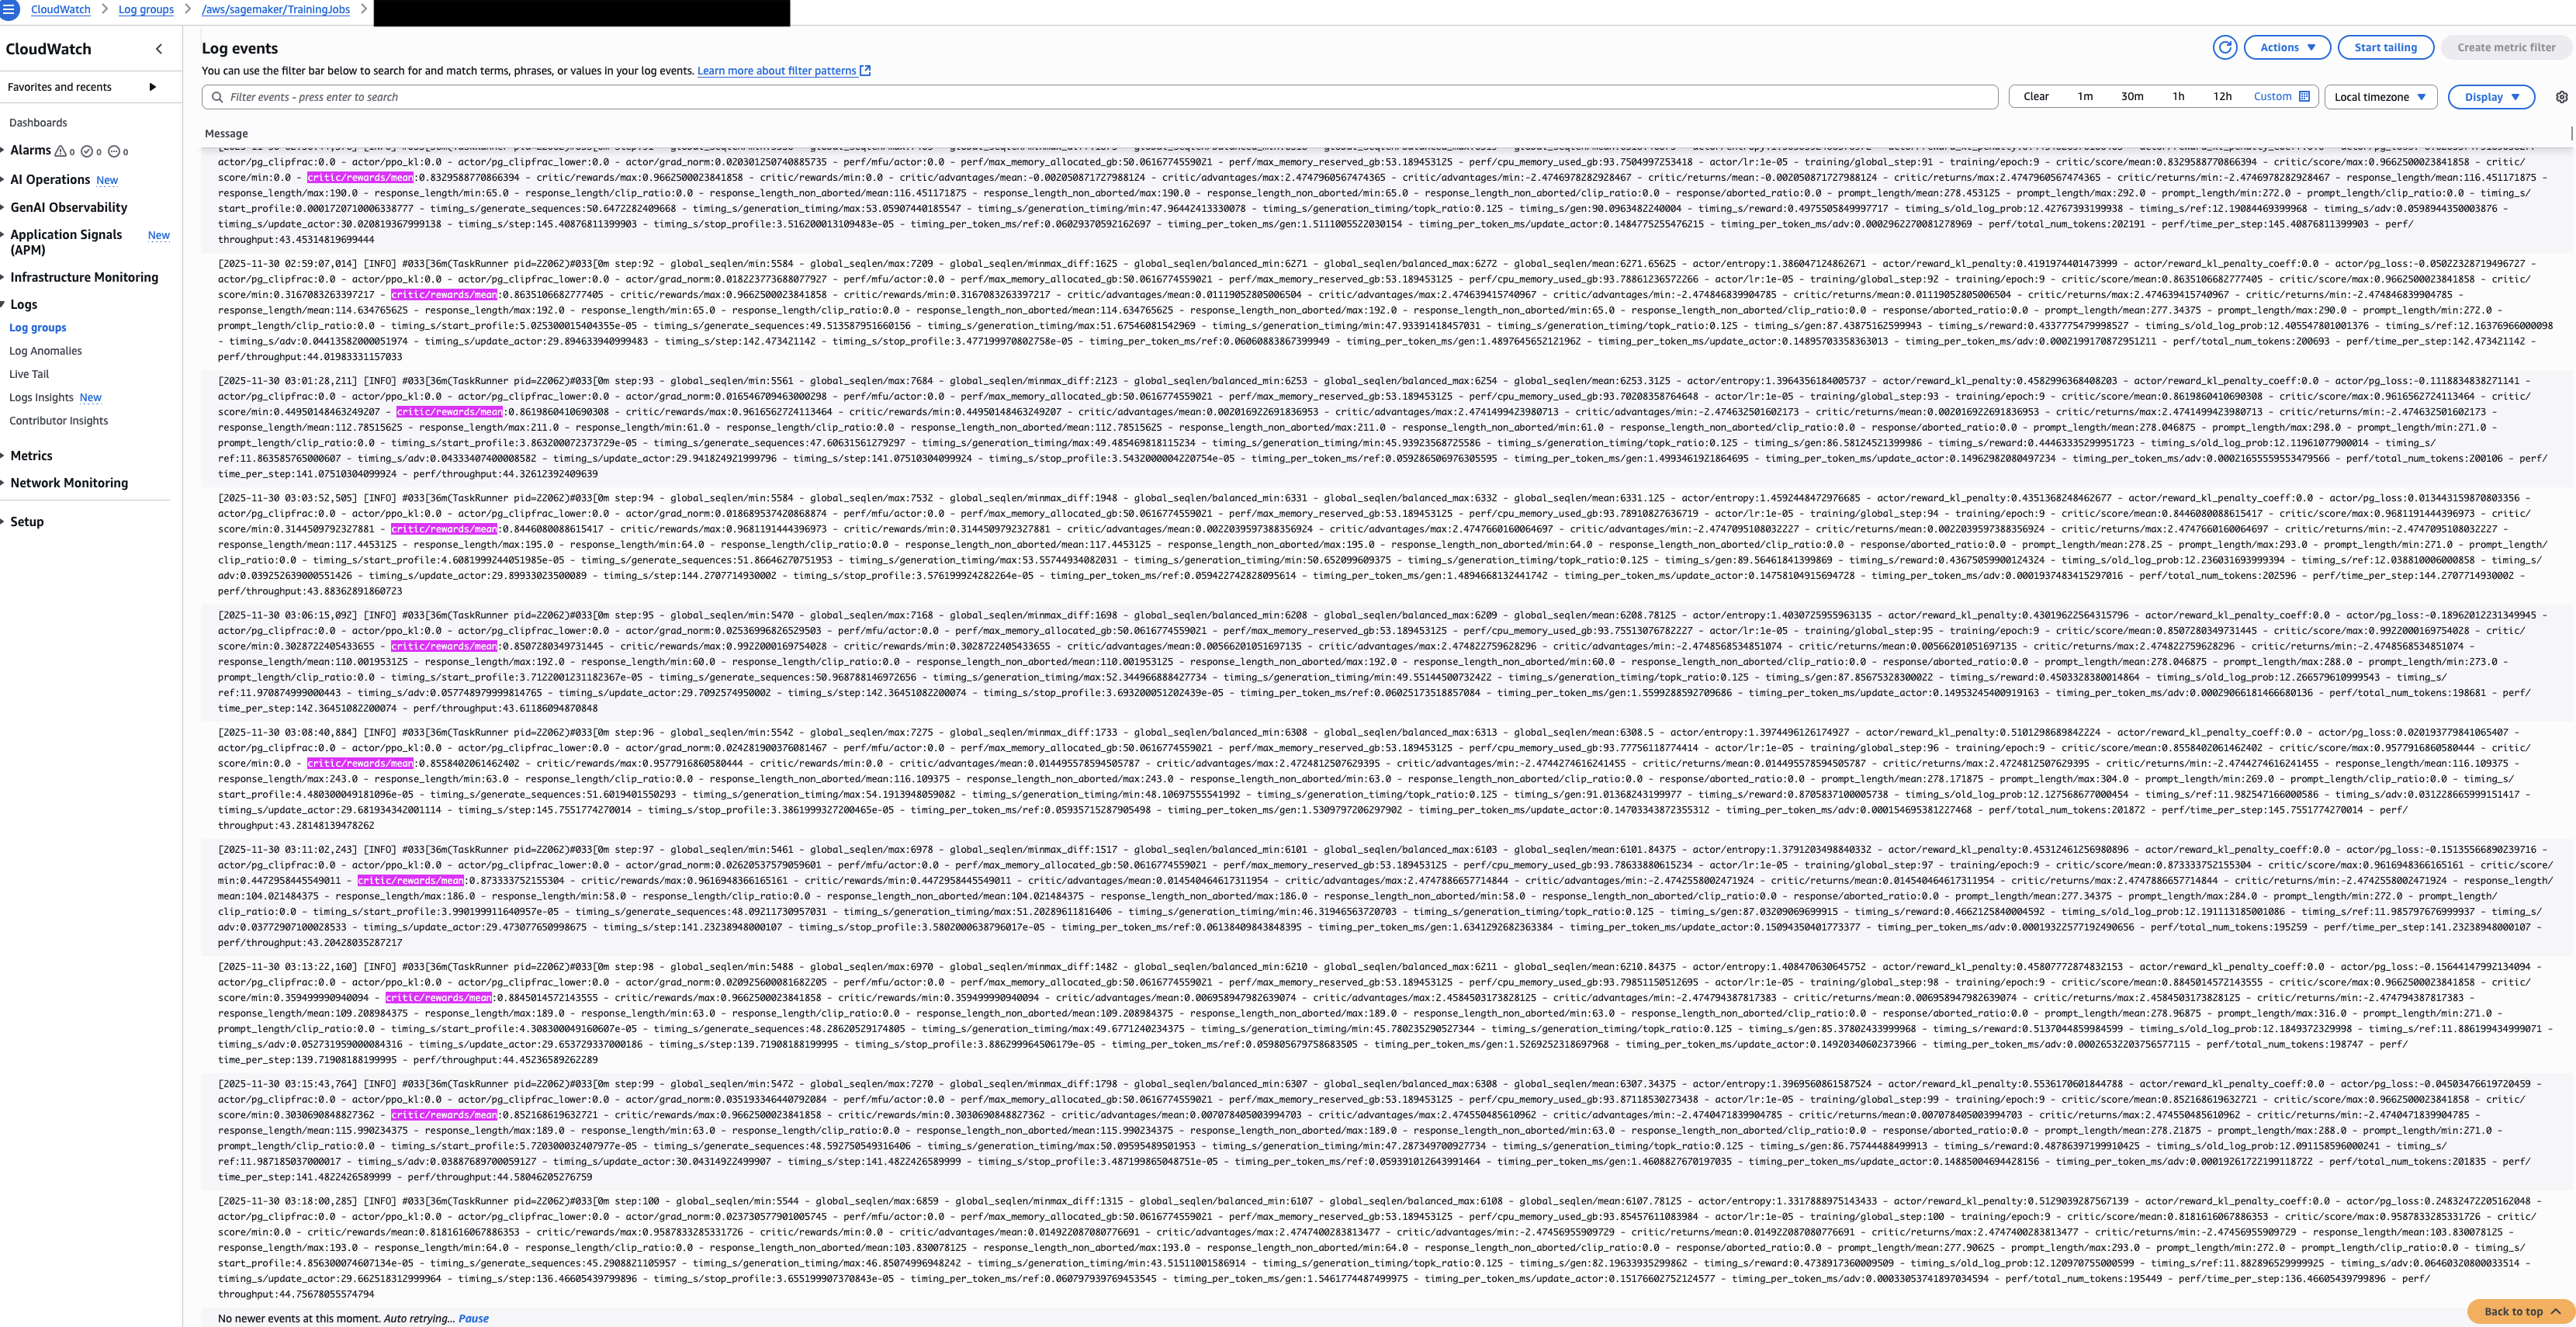

Loaded training metrics with 150 steps
Columns: ['step_number', 'epoch_number', 'train_reward_mean', 'train_episode_length_mean', 'policy_entropy', 'gradient_norm', 'mean_advantage', 'min_advantage', 'max_advantage']

Plot saved to: training_metrics_selected.png

TRAINING METRICS SUMMARY

Train Reward Mean:
  Initial: 0.817053
  Final:   0.872522
  Mean:    0.852372
  Std:     0.018013
  Min:     0.804991
  Max:     0.898037

Policy Entropy:
  Initial: 2.143865
  Final:   1.217743
  Mean:    1.582092
  Std:     0.301247
  Min:     1.135335
  Max:     2.143865

Gradient Norm:
  Initial: 0.009829
  Final:   0.022678
  Mean:    0.018277
  Std:     0.007677
  Min:     0.006516
  Max:     0.060808


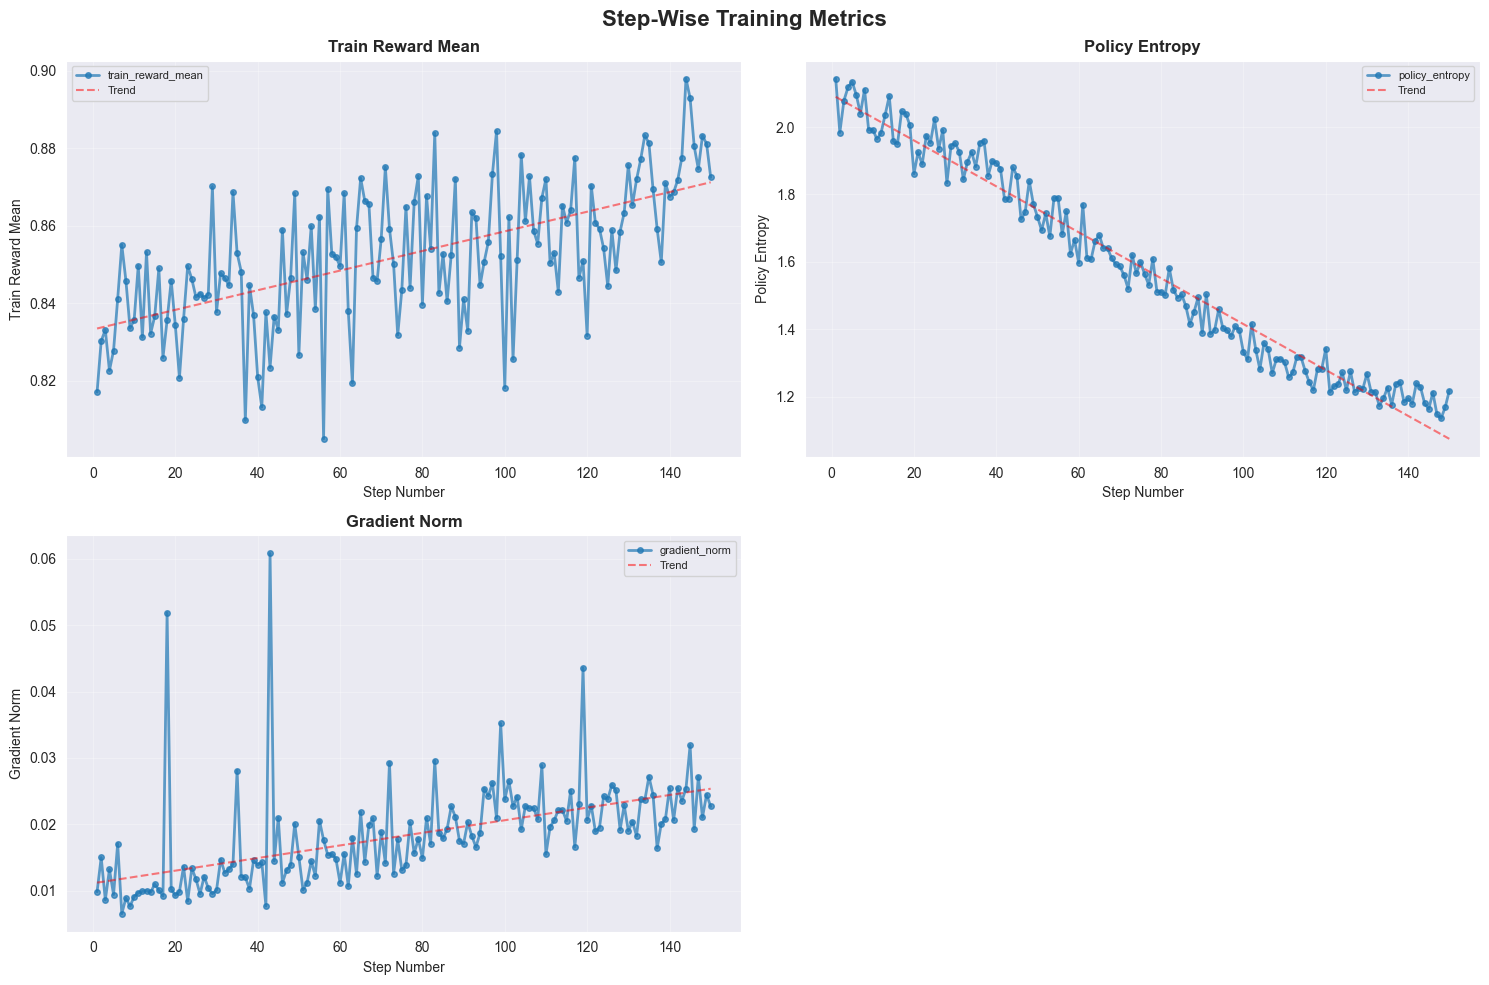

In [7]:

plot_step_wise_training_metrics(
        csv_path='./post-rft/step_wise_training_metrics.csv',
        output_path='training_metrics_selected.png',
        metrics=['train_reward_mean', 'policy_entropy', 'gradient_norm']
)

### 5. How to Evaluate the RFT custom model

For evaluation we will fetch the custom model checkpoint from manifest.json file `chkpt_info` and then override the chkpt_uri for "model_name_or_path" along with reward lambda function under "reward_lambda_arn"

#### RFT Evaluation SageMaker Training Job

Next, we define the SageMaker training Job to kick off the job with neccessary overrides.

In [ ]:
instance_type = "ml.p5.48xlarge"
instance_count = 1
image_uri = "708977205387.dkr.ecr.us-east-1.amazonaws.com/nova-evaluation-repo:SM-TJ-Eval-V2-latest"
model_id = "nova-lite-2/prod"
recipe = "evaluation/nova/nova_2_0/nova_lite/nova_lite_2_0_p5_48xl_gpu_rft_eval.yaml" # https://github.com/aws/sagemaker-hyperpod-recipes/blob/main/recipes_collection/recipes/evaluation/nova/nova_2_0/nova_lite/nova_lite_2_0_p5_48xl_gpu_rft_eval.yaml
post_sft_chkpt = chkpt_info['checkpoint_s3_bucket']

from sagemaker.pytorch import PyTorch

# define Training Job Name
job_name = f"rft-eval-{model_id.split('/')[0].replace('.', '-')}"

# define OutputDataConfig path
if default_prefix:
    output_path = f"s3://{bucket_name}/{default_prefix}/{job_name}"
else:
    output_path = f"s3://{bucket_name}/{job_name}"
    
recipe_overrides = {
    "run": {
        "model_name_or_path": post_sft_chkpt
    },
    "rl_env": {
        "reward_lambda_arn": arn
    }
}

estimator = PyTorch(
    output_path=output_path,
    base_job_name=job_name,
    role=role,
    disable_profiler=True,
    debugger_hook_config=False,
    instance_count=instance_count,
    instance_type=instance_type,
    recipe_overrides=recipe_overrides,
    training_recipe=recipe,
    sagemaker_session=sess,
    image_uri=image_uri
)


from sagemaker.inputs import TrainingInput

train_input = TrainingInput(
    s3_data=test_dataset_s3_path_rft,
    distribution="FullyReplicated"
)

estimator.fit(inputs={"train": train_input}, wait=True)

eval_job_name = estimator.latest_training_job.name
print('Evaluation Job Name:  {}'.format(eval_job_name))


In [ ]:
from IPython.display import HTML, Markdown, Image

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}">Training Job</a> After About 5 Minutes</b>'.format("us-east-1", eval_job_name)))



from IPython.display import HTML, Markdown, Image

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/TrainingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format("us-east-1", eval_job_name)))




from IPython.display import HTML, Markdown, Image

display(HTML('<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Training Job Has Completed</b>'.format(bucket_name, eval_job_name, "us-east-1")))



### 6. How to Parse Results and compare

Just like RFT, now lets unpack Eval Results to find the artifacts produced. Eval Jobs produces two key artifacts
- **Resuts JSON file**:  Results JSON file has all aggregrated metrics that are computed based on the eval metric supplied along with some pre-set metrics like precision, recall etc.
- **Results Parquet file**: Parquet File has row-by-row inference results for all the test data along with supplied ground truth values, log_probabilities and other details.

In [ ]:
response = sm.describe_training_job(
            TrainingJobName=eval_job_name
        )
        
        # Extract the model artifacts S3 URI
eval_output_s3_uri = response['ModelArtifacts']['S3ModelArtifacts']
eval_output_s3_uri = eval_output_s3_uri.replace("model.tar.gz", "output.tar.gz")

In [ ]:
files = download_and_unpack_s3_tar(
    bucket_name = bucket_name,
    s3_key=eval_output_s3_uri,
    extract_to='./post-rft-eval-results'
)

from pathlib import Path
folder = Path('./post-rft-eval-results')
json_files = list(folder.glob('*/*/*.json'))
results_file = json_files[0]

with open(results_file, 'r', encoding='utf-8') as f:
    content = f.read()
    results_data =  json.loads(content)
print("✅ Results File Loaded")


✅ Results File Loaded


### Lets load the results from the JSON File to find the eval results on our custom metrics.

In [ ]:
sft_rft_results = results_data['results']['custom|rft_eval_rft_eval|0']

sft_rft_eval_results = {
'model_conf': "SFT_RFT",
'parameter_accuracy':sft_rft_results['lambda_parameter_accuracy'],
 'schema_validation': sft_rft_results['lambda_schema_valid'],
 'tool_recall': sft_rft_results['lambda_tool_recall'],
 'sequence_accuracy': sft_rft_results['lambda_sequence_accuracy'],
 'overall_score': sft_rft_results['lambda_overall_score'],
 'tool_f1': sft_rft_results['lambda_tool_f1'],
 'tool_precision': sft_rft_results['lambda_tool_precision'],
}

new_row = pd.DataFrame([sft_rft_eval_results])
results_df= pd.concat([past_rsults_df, new_row], ignore_index=True)

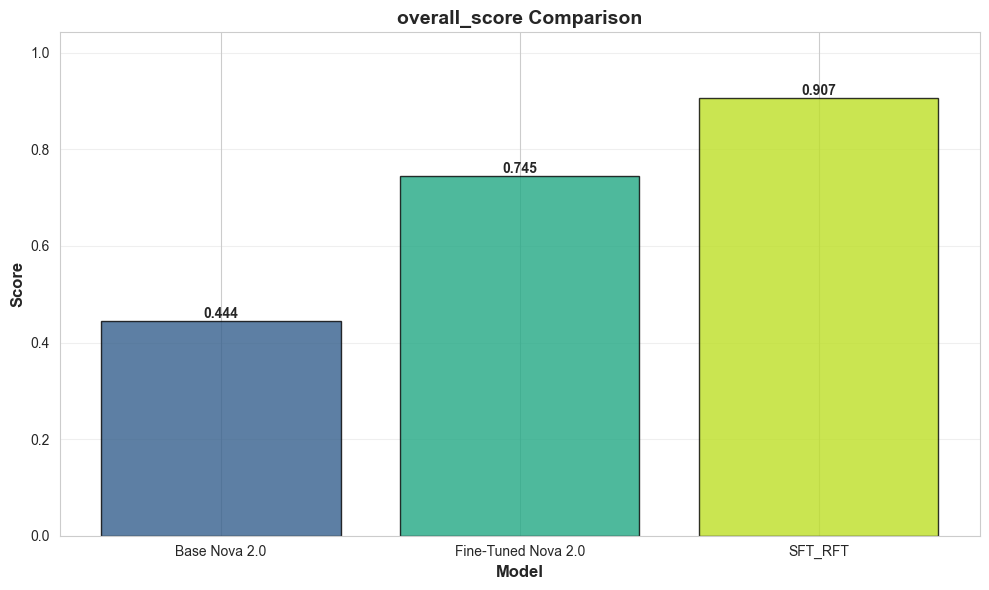

In [ ]:
from utils.plots import (
    plot_model_comparison,
    plot_single_metric_comparison
)

# Create single metric comparison
fig2 = plot_single_metric_comparison(results_df, 'overall_score')
plt.show()

/var/folders/rs/nxh2tnrd6d5gmrtsmx2_ybzh0000gr/T/ipykernel_97421/985190884.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(metric_cols, rotation=45, ha='right')


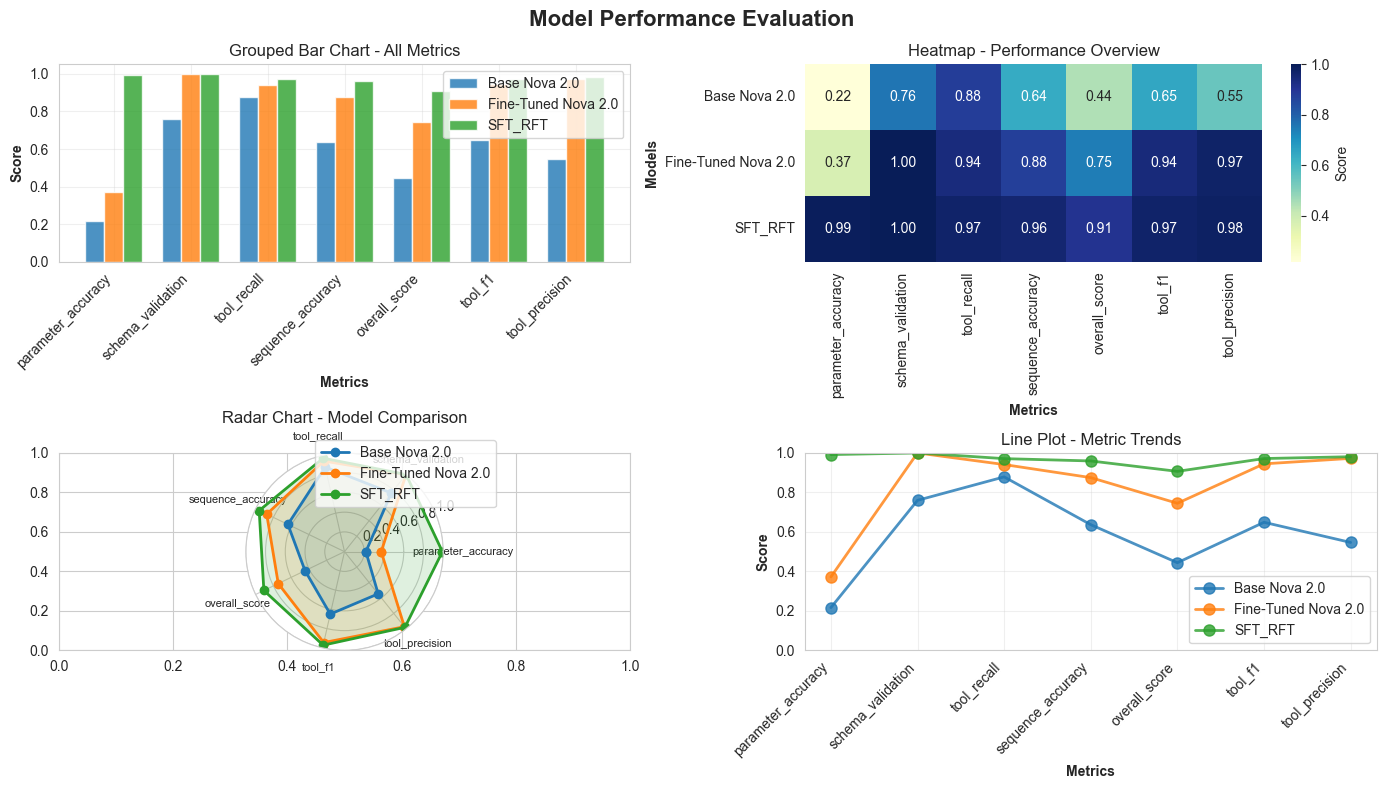

In [12]:
# Create comprehensive comparison plot
import matplotlib.pyplot as plt

fig1 = plot_model_comparison(results_df, title="Model Performance Evaluation")
plt.show()

In [ ]:
%store post_sft_chkpt